In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [97]:
### Interpreting Coefficients, Stats Model OLS ###
from statsmodels.api import OLS
grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
X = grad[grad.columns[:-1]]
y = grad[grad.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
olsreg = OLS(y_train, X_train)
olsreg = olsreg.fit()
print(olsreg.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Graduated 4-Year (%)   R-squared (uncentered):                   0.960
Model:                              OLS   Adj. R-squared (uncentered):              0.959
Method:                   Least Squares   F-statistic:                              794.8
Date:                  Sun, 15 Mar 2020   Prob (F-statistic):                   1.74e-267
Time:                          15:06:36   Log-Likelihood:                         -1437.9
No. Observations:                   406   AIC:                                      2900.
Df Residuals:                       394   BIC:                                      2948.
Df Model:                            12                                                  
Covariance Type:              nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]



As seen from Warning 2, the basic model is indeed dealing with multicollinearity. 

From Data Analysis notebook, below are features with that contain high correlations with other features that we can consider dropping to benefit our regression model

['AP-Total Exams', 'AP-Passed(%)', 'Enrolled 4-Year', 'Total Graduated', 'SAT-Total']

When thinking from a significance standpoint, we could also explore excluding 'Wealth/ADA'


In [98]:
### Studying Effects of Dropping Certain Features Due to Multicollinearity/Domain Insignificance ###
grad = grad.drop(['AP-Total Exams', 'Enrolled 4-Year', 'Total Graduated', 'AP-11&12 Participating Students', 'SAT-Total', 'Wealth/ADA'], axis=1)
X = grad[grad.columns[:-1]]
y = grad[grad.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
olsreg = OLS(y_train, X_train)
olsreg = olsreg.fit()
print(olsreg.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Graduated 4-Year (%)   R-squared (uncentered):                   0.959
Model:                              OLS   Adj. R-squared (uncentered):              0.958
Method:                   Least Squares   F-statistic:                              1544.
Date:                  Sun, 15 Mar 2020   Prob (F-statistic):                   4.71e-273
Time:                          15:06:41   Log-Likelihood:                         -1446.6
No. Observations:                   406   AIC:                                      2905.
Df Residuals:                       400   BIC:                                      2929.
Df Model:                             6                                                  
Covariance Type:              nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----


Warning about Multicollinearity is gone ^ and R2 decreased from .96 to .959 (not terrible)

Below we'll test out linear regression in scikit learn and view resulting RMSE, r2, and MAPE metrics to see if the model performs better with all features or without the features causing multicollinearity. I'll use several different testing sizes and 100 different random states for each testing size. I'll then take the average metric scores for each testing size for all features and after dropping certain features. 

Here I'm trying to eliminate bias for how the data was split up into training and testing sets to make a reasonable conclusion on how dropping certain features affects model performance. 


In [15]:
########## Linear Regression Model for Predicting Graduated 4-Year (%) ############

### USING DIFFERENT RANDOM STATES AND DIFFERENT TEST SPLITS ####

### ALL Features ###
from sklearn.metrics.scorer import make_scorer

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for test_size in [.275, .25, .225, .2]:
    rmse_all = []
    r2_all = []
    mape_all = []
    rmse_drop = []
    r2_drop = []
    mape_drop = []
    print('\n***Test Size: ', test_size, '***')
    for i in range(1000):
        ### ALL FEATURES ###
        grad = pd.read_csv('Feature_Target_Data.csv')
        years = [2011, 2012, 2013, 2014]
        grad = grad.loc[grad['Year'].isin(years)]
        grad = grad[grad.columns[3:]]
        X = grad.drop('Graduated 4-Year (%)', axis=1).values
        y = grad['Graduated 4-Year (%)'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        linear_reg = LinearRegression()
        linear_reg.fit(X_train, y_train)
        y_pred_test = linear_reg.predict(X_test)
        y_pred_train = linear_reg.predict(X_train)
        rmse_all.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        r2_all.append(linear_reg.score(X_test, y_test))
        mape_all.append(mean_absolute_percentage_error(y_test, y_pred_test))
        r2_max_index = r2_all.index(np.max(r2_all))        
        rmse_max_index = rmse_all.index(np.min(rmse_all))
        mape_max_index = mape_all.index(np.min(mape_all))
        ### After Dropping Features Causing Mulicollinearity ###
        X2 = grad.drop(['Graduated 4-Year (%)', 'AP-Total Exams', 'Enrolled 4-Year', 'Total Graduated', 'AP-11&12 Participating Students', 'SAT-Total', 'Wealth/ADA'], axis=1).values
        y2 = grad['Graduated 4-Year (%)'].values
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=test_size, random_state=i)
        linear_reg = LinearRegression()
        linear_reg.fit(X_train2, y_train2)
        y_pred_test2 = linear_reg.predict(X_test2)
        y_pred_train2 = linear_reg.predict(X_train2)
        rmse_drop.append(np.sqrt(mean_squared_error(y_test2, y_pred_test2)))
        r2_drop.append(linear_reg.score(X_test2, y_test2))
        mape_drop.append(mean_absolute_percentage_error(y_test2, y_pred_test2))
        r2_max_index2 = r2_drop.index(np.max(r2_drop))        
        rmse_max_index2 = rmse_drop.index(np.min(rmse_drop))
        mape_max_index2 = mape_drop.index(np.min(mape_drop))
    print('*All Features: Performance on Test Set*')
    print('\nAverage Results from different Random States:')
    print('RMSE: ', np.mean(rmse_all), 'r2: ', np.mean(r2_all), 'MAPE: ', np.mean(mape_all))
    print('\nBest RMSE: ', rmse_all[rmse_max_index], 'Random State: ', rmse_max_index)
    print('Best r2: ', r2_all[r2_max_index], 'Random State: ', r2_max_index)
    print('Best MAPE: ', mape_all[mape_max_index], 'Random State: ', mape_max_index)

    print('\n*After Dropping Features: Performance on Test Set*')
    print('\nAverage Results from different Random States:')
    print('RMSE: ', np.mean(rmse_drop), 'r2: ', np.mean(r2_drop), 'MAPE: ', np.mean(mape_drop))
    print('\nBest RMSE: ', rmse_drop[rmse_max_index2], 'Random State: ', rmse_max_index2)
    print('Best r2: ', r2_drop[r2_max_index2], 'Random State: ', r2_max_index2)
    print('Best MAPE: ', mape_drop[mape_max_index2], 'Random State: ', mape_max_index2)




***Test Size:  0.275 ***
*All Features: Performance on Test Set*

Average Results from different Random States:
RMSE:  8.024981633156637 r2:  0.5808002398725814 MAPE:  17.746177379426808

Best RMSE:  6.5780572094757215 Random State:  657
Best r2:  0.7024134573472549 Random State:  926
Best MAPE:  13.670654224423245 Random State:  178

*After Dropping Features: Performance on Test Set*

Average Results from different Random States:
RMSE:  8.134285510326231 r2:  0.5693447328370037 MAPE:  17.785877371894035

Best RMSE:  6.501762627984149 Random State:  319
Best r2:  0.7178792180167728 Random State:  319
Best MAPE:  13.453253962546366 Random State:  178

***Test Size:  0.25 ***
*All Features: Performance on Test Set*

Average Results from different Random States:
RMSE:  8.017852279775068 r2:  0.5806564816476749 MAPE:  17.71832721888505

Best RMSE:  6.38238954547272 Random State:  118
Best r2:  0.7024513998328827 Random State:  926
Best MAPE:  13.474187318294028 Random State:  178

*After 


********* SUMMARY OF ALL THE ABOVE CELLS/EXERCISES *********************

1. 
I started with an OLS model in which I utilized all of the features I collected. I utilized a 75 - 25 split and a random state of 42. After training and fitting the model, I printed out a summary of the OLS model in which R2 was .96
I also received a multicollinearity warning in the summary as the condition number was too high. 

2. 
After finding the features that are causing the collinearity in the Data Analysis notebook, I dropped the features and repeated (1) with the same train test split and random state. I found that R2 barely decreased from .96 to .959 and that the multicollinearity warning was gone. 

3. 
I then utilized linear regression in scikit learn to the view resulting RMSE, r2, and MAPE metrics for evaluating model performance with all features versus without the features causing multicollinearity. I used several different testing sizes and 1000 different random states for each testing size. I then took the average metric scores for each testing size for all features and after dropping certain features. I did this to eliminate bias for how the data was split up into training and testing sets to make a reasonable conclusion on how dropping certain features affects model performance. 

For all the different testing sizes and random states, I can not reasonably say that dropping certain features will result in a better performing Linear Regression model. 

I also provided the best results for each case to use going forward as our goal is to get the best performing model. Once again, we cant see a consistent trend in the difference between the best scores for all features versus dropping select features. 

Going forward, I will use all available features, testing size of .2, and random state of 639. 


In [38]:
#### Evaluating Ridge and Lasso Model Performance ####
### ALSO ADDING SCALER (Robust Gave Best Results) ###

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer, StandardScaler
from sklearn.model_selection import GridSearchCV


grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
linear_reg = LinearRegression()
steps = [('scaler', RobustScaler()), ('reg', LinearRegression())]
linear_reg = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=639)
linear_reg.fit(X_train, y_train)
y_pred_train = linear_reg.predict(X_train)
y_pred_test = linear_reg.predict(X_test)
print('Linear Regression')
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)), 'Testing RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTraining R2: ', linear_reg.score(X_train, y_train), 'Testing R2: ', linear_reg.score(X_test, y_test))
print('\nTraining MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train), 'Testing MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))



for regression_model in [Ridge(), Lasso()]:
    print('\n' + str(regression_model))
    steps = [('scaler', RobustScaler()), ('reg', regression_model)]
    pipeline = Pipeline(steps)
    params = {'reg__alpha': [.00001, .0001, .001, .01, .1]}
    reg = GridSearchCV(pipeline, param_grid=params, cv=5)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    print('Training RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)), 'Testing RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('\nTraining R2: ', reg.score(X_train, y_train), 'Testing R2: ', reg.score(X_test, y_test))
    print('\nTraining MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train), 'Testing MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))


Linear Regression
Training RMSE: 8.205665471245794 Testing RMSE: 6.198273680955048

Training R2:  0.5754095033931913 Testing R2:  0.7441823938418588

Training MAPE:  18.109866126554923 Testing MAPE:  14.549309277352723

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Training RMSE: 8.205669056585874 Testing RMSE: 6.198721955015161

Training R2:  0.5754091323564576 Testing R2:  0.7441453898147055

Training MAPE:  18.109189420233786 Testing MAPE:  14.554301954466315

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Training RMSE: 8.2374949316565 Testing RMSE: 6.239775007211057

Training R2:  0.5721091744835733 Testing R2:  0.740745206829085

Training MAPE:  18.012894440793335 Testing MAPE:  14.813833443845095



In terms of model performance, Ridge and Lasso failed to beat out the Linear regression model, but were very close. Below we can further explore the Linear Regression model with a couple of plots.

Text(0.5, 1.0, 'Actual vs Predicted')

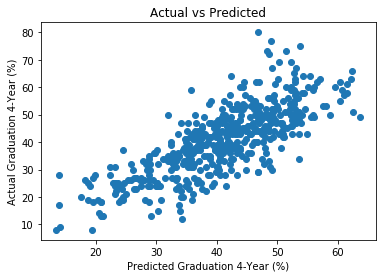

In [40]:
### Actual vs Predicted Scatterplot ###
import matplotlib.pyplot as plt

actual = y
predicted = linear_reg.predict(X)
plt.scatter(predicted, actual)
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Actual Graduation 4-Year (%)')
plt.title('Actual vs Predicted')

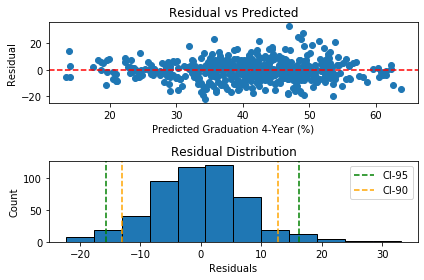

In [62]:
### Predicted vs Residuals Scatterplot ###
plt.subplot(2,1,1)
residuals = actual - predicted
plt.scatter(predicted, residuals)
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Residual')
plt.title('Residual vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')

### Residuals Histogram ###
plt.subplot(2,1,2)
plt.hist(residuals, bins=12, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Distribution')
conf_int95 = np.percentile(residuals, [2.5, 97.5])
conf_int90 = np.percentile(residuals, [5, 95])
plt.axvline(x=conf_int95[0], color='green', linestyle='--', label='CI-95')
plt.axvline(x=conf_int95[1], color='green', linestyle='--')
plt.axvline(x=conf_int90[0], color='orange', linestyle='--', label='CI-90')
plt.axvline(x=conf_int90[1], color='orange', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


While the Linear regression model is the best so far, I believe a random forest regression will solve many of the concerns with the size of the dataset and the random state influence. Each tree will draw a random sample from the original data set when generating its splits, adding a further element of randomness that prevents overfitting.

The number of features that can be split on at each node is limited to some percentage of the total, which will also help ensures that the ensemble model does not rely too heavily on any individual feature. This makes fair use of all potentially predictive features and helps the issues of multicollinearity explored at the beginning of this notebook. 

The above modifications help prevent the trees from being too highly correlated

OOB Score 0.6038270979402521
CV - R2:  0.5794867803774137
CV - RMSE 8.046683552569263

Testing RMSE: 6.219713751732698

Testing R2:  0.7424095668119244

Testing MAPE:  15.408089588795038


____Feature Importance Plot_____


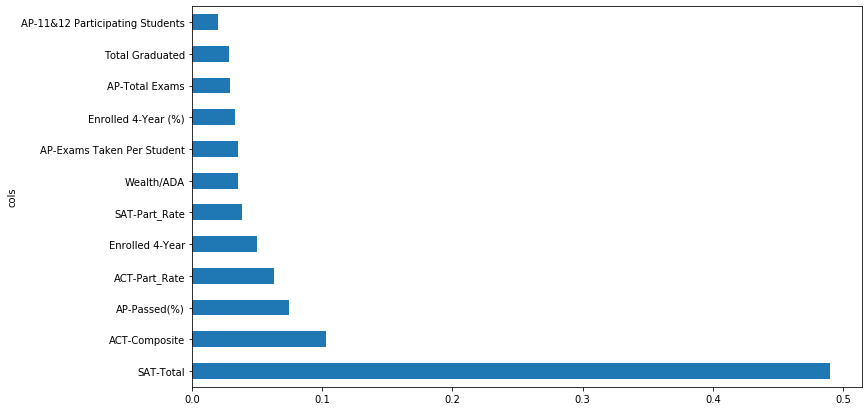

In [68]:
####### RandomForestRegressor #########
### All Features ###

from sklearn.ensemble import RandomForestRegressor


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=639)
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True)
rfr.fit(X_train, y_train)
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
cv_score_r2 = cross_val_score(rfr, X_train, y_train, cv=4, scoring='r2')
cv_score_rmse = cross_val_score(rfr, X_train, y_train, cv=4, scoring='neg_mean_squared_error')
fi = rf_feat_importance(rfr, grad[grad.columns[:-1]])
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi)
print('OOB Score', rfr.oob_score_)
print('CV - R2: ', np.mean(cv_score_r2))
print('CV - RMSE', np.mean(np.sqrt(abs(cv_score_rmse))))
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', rfr.score(X_test, y_test))
print('\nTesting MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))
print('\n\n____Feature Importance Plot_____')



In [69]:
### Random Forest Regressor Without Any HyperParameter Tuning ###
### After Dropping Certain Features ###

from sklearn.model_selection import cross_val_score

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
grad = grad.drop(['AP-11&12 Participating Students', 'AP-Total Exams', 'Total Graduated'], axis=1)
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=639)
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True)
rfr.fit(X_train, y_train)
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
cv_score_r2 = cross_val_score(rfr, X_train, y_train, cv=4, scoring='r2')
cv_score_rmse = cross_val_score(rfr, X_train, y_train, cv=4, scoring='neg_mean_squared_error')

print('OOB Score', rfr.oob_score_)
print('CV - R2: ', np.mean(cv_score_r2))
print('CV - RMSE', np.mean(np.sqrt(abs(cv_score_rmse))))
print('\nTraining RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)), 'Testing RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTraining R2: ', rfr.score(X_train, y_train), 'Testing R2: ', rfr.score(X_test, y_test))
print('\nTraining MAPE: ', mean_absolute_percentage_error(y_train, y_pred_train), 'Testing MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))


OOB Score 0.6024895629436385
CV - R2:  0.583799710313932
CV - RMSE 7.9847599573852985

Training RMSE: 2.9073156080254177 Testing RMSE: 6.126601604290991

Training R2:  0.9467000239769512 Testing R2:  0.750064345562721

Training MAPE:  6.489794156751086 Testing MAPE:  15.175057714591192


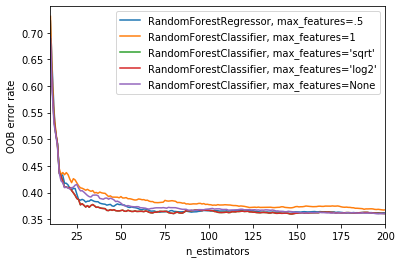

In [9]:
### Exploring OBB Errors, Max_Features, N_Estimators #####

from collections import OrderedDict

RANDOM_STATE = 639
ensemble_clfs = [
     ("RandomForestRegressor, max_features=.5",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features=.5,
                               random_state=RANDOM_STATE)),
     ("RandomForestClassifier, max_features=1",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features=1,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 10
max_estimators = 200
for label, rfr in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        rfr.set_params(n_estimators=i)
        rfr.fit(X, y)
        oob_error = 1 - rfr.oob_score_
        error_rate[label].append((i, oob_error))
for label, rfr_err in error_rate.items():
    xs, ys = zip(*rfr_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [65]:
### HyperParamter Tuning ###
### All Features ###
scorers = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'}

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=639)
rfr = RandomForestRegressor(n_jobs=-1, random_state=639, criterion='mse', oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = scorers, refit = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)
OOB = grid_search.best_estimator_
print('\nOOB Score: ', OOB.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('CV - Best Score RMSE: ', min(np.sqrt(abs(grid_search.cv_results_['mean_test_mse']))))
print('CV - Best Score R2: ', grid_search.best_score_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))
print('\nTesting MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))


OOB Score:  0.6159060637474676

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}
CV - Best Score RMSE:  7.915400613052948
CV - Best Score R2:  0.5964734926170435

Testing RMSE: 6.214637833657039

Testing R2:  0.7428298351581777

Testing MAPE:  15.143943380490605


In [64]:
### HyperParameter Tuning ###
### Dropping Certain Features ###

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
grad = grad.drop(['AP-11&12 Participating Students', 'AP-Total Exams', 'Total Graduated', 'Enrolled 4-Year (%)'], axis=1)
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=639)
rfr = RandomForestRegressor(n_jobs=-1, random_state=639, criterion='mse', oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = scorers, refit = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)
OOB = grid_search.best_estimator_
print('\nOOB Score: ', OOB.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('CV - Best Score RMSE: ', min(np.sqrt(abs(grid_search.cv_results_['mean_test_mse']))))
print('CV - Best Score R2: ', grid_search.best_score_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))
print('\nTesting MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))


OOB Score:  0.6105412970855798

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}
CV - Best Score RMSE:  7.866229121528453
CV - Best Score R2:  0.600891663268329

Testing RMSE: 6.128188360330119

Testing R2:  0.7499348648843283

Testing MAPE:  15.185230810074193


In [67]:
### Shuffling Training Data ###

grad = pd.read_csv('Feature_Target_Data.csv')
years = [2011, 2012, 2013, 2014]
grad = grad.loc[grad['Year'].isin(years)]
grad = grad[grad.columns[3:]]
grad = grad.drop(['AP-11&12 Participating Students', 'AP-Total Exams', 'Total Graduated', 'Enrolled 4-Year (%)'], axis=1)
X = grad.drop('Graduated 4-Year (%)', axis=1).values
y = grad['Graduated 4-Year (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=639)
rfr = RandomForestRegressor(n_jobs=-1, criterion='mse', oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = scorers, refit = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)
OOB = grid_search.best_estimator_
print('\nOOB Score: ', OOB.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('CV - Best Score RMSE: ', min(np.sqrt(abs(grid_search.cv_results_['mean_test_mse']))))
print('CV - Best Score R2: ', grid_search.best_score_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))
print('\nTesting MAPE: ', mean_absolute_percentage_error(y_test, y_pred_test))


OOB Score:  0.612505757170242

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 600}
CV - Best Score RMSE:  7.850698236998814
CV - Best Score R2:  0.6029203535297465

Testing RMSE: 6.10987153382589

Testing R2:  0.7514274934202592

Testing MAPE:  15.051822216364869


The introduced randomness above helped the model train on folds containing different records of the training data. In this case, it resulted in better performance on the test set. This will be the model I will utilize going forward.

Text(0.5, 1.0, 'Actual vs Predicted')

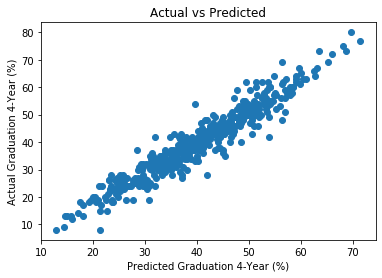

In [71]:
### Actual vs Predicted Scatterplot ###
actual = y
predicted = grid_search.predict(X)
plt.scatter(predicted, actual)
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Actual Graduation 4-Year (%)')
plt.title('Actual vs Predicted')

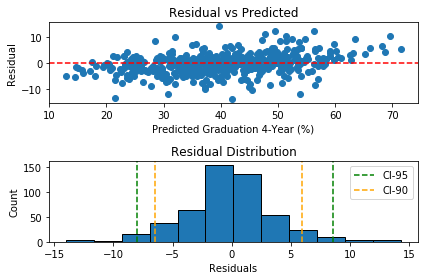

In [72]:
### Predicted vs Residuals Scatterplot ###
plt.subplot(2,1,1)
residuals = actual - predicted
plt.scatter(predicted, residuals)
plt.xlabel('Predicted Graduation 4-Year (%)')
plt.ylabel('Residual')
plt.title('Residual vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')

### Residuals Histogram ###
plt.subplot(2,1,2)
plt.hist(residuals, bins=12, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Distribution')
conf_int95 = np.percentile(residuals, [2.5, 97.5])
conf_int90 = np.percentile(residuals, [5, 95])
plt.axvline(x=conf_int95[0], color='green', linestyle='--', label='CI-95')
plt.axvline(x=conf_int95[1], color='green', linestyle='--')
plt.axvline(x=conf_int90[0], color='orange', linestyle='--', label='CI-90')
plt.axvline(x=conf_int90[1], color='orange', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
### Filling In / Predicting 2015, 2016, 2017 ###
historical = pd.read_csv('Feature_Target_Data.csv')
predicted = historical.fillna('NaN')
predicted = predicted[predicted.columns[3:]]
predicted = predicted.drop(['AP-11&12 Participating Students', 'AP-Total Exams', 'Total Graduated', 'Enrolled 4-Year (%)'], axis=1)
columns = list(predicted.columns[:-1])
print(predicted.head(20))
for idx, row in predicted.iterrows():
    if row['Graduated 4-Year (%)'] == 'NaN':
        features = [row[col] for col in columns]
        features = np.array(features).reshape(1, -1)
        predicted.loc[idx, 'Graduated 4-Year (%)'] = grid_search.predict(features)
print(predicted.head(40))

    ACT-Composite  ACT-Part_Rate  AP-Passed(%)  AP-Exams Taken Per Student  \
0            24.2             51            66                         2.2   
1            23.9             52            66                         2.4   
2            24.7             65            69                         2.3   
3            24.7             59            74                         2.3   
4            24.5             60            72                         2.3   
5            24.0             65            77                         2.4   
6            24.5             63            75                         2.4   
7            17.7             26            16                         1.8   
8            17.7             29            19                         1.7   
9            17.8             29            18                         1.8   
10           17.7             37            17                         1.8   
11           18.2             21            14                  

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').